In [1]:
import os
import sys

os.chdir("../..")
sys.path.append("..")

In [2]:
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.transform import log_cmap, linear_cmap
from bokeh.util.hex import hexbin, cartesian_to_axial
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import ValidationDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature import (
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
    MonthOfYear
)
from gluonts.torch.batchify import batchify
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    InstanceSplitter,
    ValidationSplitSampler
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm

from src.models.utils import get_model
from src.utils.data_loading import load_features, load_score, load_train_data
from src.utils.evaluation import score_batch

/anaconda/envs/whatif/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
model_name = "nbeats_g"
dataset = "electricity_nips"

datadir = f"data/{dataset}"
generated_datadir = os.path.join(f"/datadrive2/whatif/{dataset}", "generated", "test")

original_experiment_dir = f"experiments/{dataset}/{model_name}"
new_experiment_dir = f"experiments/{dataset}/{model_name}_gen_seas_dec"
metric = "mae"

In [4]:
with open(os.path.join(original_experiment_dir, "config.yaml"), "r") as f:
    original_config = yaml.load(f, Loader=yaml.FullLoader)

with open(os.path.join(new_experiment_dir, "config.yaml"), "r") as f:
    new_config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

original_model = get_model(original_config["model_name"])(**original_config["model_args"], device=device, path=original_config["path"]).to(device)
original_model.load_state_dict(torch.load(os.path.join(original_config["path"], "model.pth")))

new_model = get_model(new_config["model_name"])(**new_config["model_args"], device=device, path=new_config["path"]).to(device)
new_model.load_state_dict(torch.load(os.path.join(new_config["path"], "model.pth")))

<All keys matched successfully>

In [6]:
original_scores = load_score(original_experiment_dir, metric)
new_scores = load_score(new_experiment_dir, metric)

original_scores.shape, new_scores.shape

((2590, 24), (2590, 24))

In [7]:
train_features = load_features(datadir, train=True)
test_features = load_features(datadir, train=False)
train_features.shape, test_features.shape

((25600, 4), (2590, 4))

In [8]:
scaler = StandardScaler()
norm_train_features = scaler.fit_transform(train_features)
norm_test_features = scaler.transform(test_features)

pca = PCA(n_components=2)
train_pca_data = pca.fit_transform(norm_train_features)
test_pca_data = pca.transform(norm_test_features)

In [9]:
def load_generated_data(feature_prefix, generated_test_datadir, len_test_data):
    features = [0 for _ in range(len_test_data)]
    for f in os.listdir(generated_test_datadir):
        if f.startswith(feature_prefix):
            file_name = f.split(".")[0]  # slice off .npy from file name
            ts_idx = int(file_name[len(feature_prefix):])  # the remaining charachters after prefix is always the time series id
            features[ts_idx] = np.load(os.path.join(generated_test_datadir, f))

    features = np.array(features)  # [len(original_test), num_manipulations, 4]
    return features

In [10]:
data_prefix = "ts_seasonal_str"
feature_prefix = "feat_seasonal_str"

gen_ts = load_generated_data(data_prefix, generated_datadir, original_scores.shape[0])
gen_features = load_generated_data(feature_prefix, generated_datadir, original_scores.shape[0])

gen_ts = gen_ts[:, -1, :].reshape([-1, original_config["context_length"] + original_config["prediction_length"]])
gen_features = gen_features[:, -1, :].reshape([-1, 4])  # flatten the two first dimensions
gen_ts.shape, gen_features.shape

((2590, 192), (2590, 4))

(-4.0, 9.0)

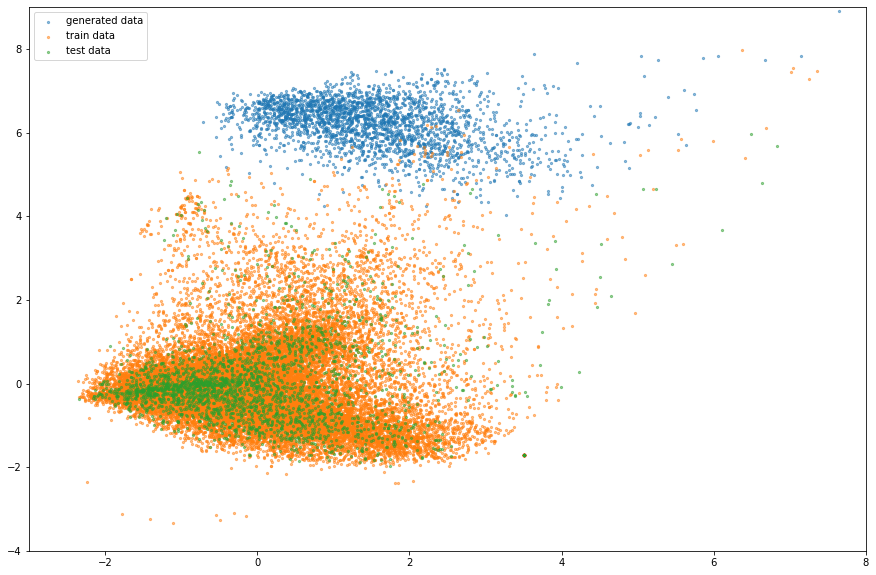

In [11]:
norm_gen_features = scaler.transform(gen_features)
gen_pca_data = pca.transform(norm_gen_features)

plt.figure(figsize=(15, 10))

plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label="generated data", s=5, alpha=0.5)
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.legend()
plt.xlim([-3, 8])
plt.ylim([-4, 9])

In [12]:
def create_gen_dataloader(generated_data, dataset, context_length, prediction_length, batch_size):
    original_dataset = get_dataset(dataset)
    
    # nbeats doesn't do any covariates so we don't care that the starting points of forecasts are wrong here
    list_data = [{"start": original["start"], "target": generated, "feat_static_cat": original["feat_static_cat"], "item_id": original["item_id"]}
                 for original, generated in zip(original_dataset.test, generated_data)]
    generated_dataset = ListDataset(list_data, freq=original_dataset.metadata.freq)
    
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ValidationSplitSampler(min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = ValidationDataLoader(
        generated_dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_workers=1
    )
    return dataloader

In [13]:
def organize_scores(all_scores, metric):
    mape = []
    smape = []
    mase = []
    seasonal_mase = []
    mse = []
    mae = []
    for score in all_scores:
        mape.append(score[0])
        smape.append(score[1])
        mase.append(score[2])
        seasonal_mase.append(score[3])
        mse.append(score[4])
        mae.append(score[5])


    mape = np.vstack(mape)
    smape = np.vstack(smape)
    mase = np.vstack(mase)
    seasonal_mase = np.vstack(seasonal_mase)
    mse = np.vstack(mse)
    mae = np.vstack(mae)
    
    return {"mape": mape, "smape": smape, "mase": mase, "seasonal_mase": seasonal_mase, "mse": mse, "mae": mae}[metric]

In [14]:
gen_dataloader = create_gen_dataloader(gen_ts, dataset, original_config["trainer_args"]["context_length"],
                                       original_config["trainer_args"]["prediction_length"], original_config["trainer_args"]["batch_size"])

original_gen_scores = []
new_gen_scores = []
original_model.eval()
new_model.eval()
for batch in tqdm(gen_dataloader):
    original_preds = original_model.predict(batch)[:, :, 0]
    new_preds = new_model.predict(batch)[:, :, 0]

    context = batch["past_target"].unsqueeze(dim=-1).numpy()
    target = batch["future_target"].numpy()
    
    original_gen_scores.append(score_batch(target, original_preds, context, original_config["sp"]))
    new_gen_scores.append(score_batch(target, new_preds, context, new_config["sp"]))

original_gen_scores = organize_scores(original_gen_scores, metric)
new_gen_scores = organize_scores(new_gen_scores, metric)

original_gen_scores.shape, new_gen_scores.shape

6it [00:02,  2.60it/s]


((2590, 24), (2590, 24))

In [15]:
np.isnan(original_gen_scores).sum(), np.isnan(new_gen_scores).sum()

(0, 0)

In [16]:
print(f"Original model score on OOD test data: {np.nanmean(original_gen_scores)}")
print(f"New model score on OOD test data: {np.nanmean(new_gen_scores)}")
print(f"Percentage change for new model: {np.abs(np.nanmean(original_gen_scores) - np.nanmean(new_gen_scores)) / np.nanmean(original_gen_scores)}")
print()

print(f"Original model score on original test_data: {np.nanmean(original_scores)}")
print(f"New model score on original test_data: {np.nanmean(new_scores)}")
print(f"Percentage change for new model: {np.abs(np.nanmean(original_scores) - np.nanmean(new_scores)) / np.nanmean(original_scores)}")
print()

print(f"Original model average score: {np.nanmean(np.concatenate([original_scores, original_gen_scores], axis=0))}")
print(f"New model average score: {np.nanmean(np.concatenate([new_scores, new_gen_scores], axis=0))}")

Original model score on OOD test data: 38.066439593930404
New model score on OOD test data: 25.910661584614616
Percentage change for new model: 0.31933057409587623

Original model score on original test_data: 44.00199646847652
New model score on original test_data: 44.284289411936726
Percentage change for new model: 0.006415457618211562

Original model average score: 41.034218031203466
New model average score: 35.09747549827567


In [17]:
original_scores = np.concatenate([original_scores, original_gen_scores], axis=0)
new_scores = np.concatenate([new_scores, new_gen_scores], axis=0)

original_scores.shape, new_scores.shape

((5180, 24), (5180, 24))

In [18]:
concat_pca_data = np.concatenate([test_pca_data, gen_pca_data], axis=0)

test_bins = hexbin(concat_pca_data[:, 0], concat_pca_data[:, 1], 0.1)
test_bins

,q,r,counts
0,-15,3,1
1,-13,1,1
2,-13,2,13
3,-13,4,1
4,-12,0,5
...,...,...,...
1043,65,-52,1
1044,67,-52,1
1045,74,-59,1
1046,76,-66,1


In [19]:
output_notebook()

p = figure(title=f"Distributions of generated and original test data for {dataset}", tools="", match_aspect=True, background_fill_color="#440154",
          x_range=[-3, 8], y_range=[-4, 9])
p.grid.visible=False
p.hex_tile(q="q", r="r", size=0.1, line_color=None, source=test_bins, fill_color=log_cmap("counts", "Viridis256", 1, max(test_bins.counts)))

layout = row([p])
show(layout)

Loading BokehJS ...

In [20]:
def create_color_arr(scores, quantiles=None):
    if quantiles is None:
        quantiles = np.nanquantile(scores, [0.25, 0.75])
    
    low = scores < quantiles[0]
    high = scores > quantiles[1]
    medium = np.logical_and(~low, ~high)
    
    colors = np.empty_like(scores)
    colors[low] = 0
    colors[medium] = 1
    colors[high] = 2
    
    return colors

In [21]:
def color_bin(bins, pca_data, colors, column_name):
    q, r = cartesian_to_axial(pca_data[:, 0], pca_data[:, 1], 0.1, "pointytop")
    df = pd.DataFrame(dict(r=r, q=q))
    groups = df.groupby(["q", "r"])
    
    for (q, r), indexes in groups.groups.items():
        color = np.nanmean(colors[indexes])
        bins.loc[(bins["q"] == q) & (bins["r"] == r), column_name] = color
    
    return bins

In [22]:
test_bins["original_colors"] = np.nan
test_bins["new_colors"] = np.nan

In [23]:
original_ts_scores = np.nanmean(original_scores, axis=-1)  # clip at 4 like paper
new_ts_scores = np.nanmean(new_scores, axis=-1)

orig_quantiles = np.nanquantile(original_ts_scores, [0.25, 0.75])
original_colors = create_color_arr(original_ts_scores, orig_quantiles)
new_colors = create_color_arr(new_ts_scores, orig_quantiles)

test_bins = color_bin(test_bins, concat_pca_data, original_colors, "original_colors")
test_bins = color_bin(test_bins, concat_pca_data, new_colors, "new_colors")

In [24]:
f"original colors min/max: {min(test_bins.original_colors)}/{max(test_bins.original_colors)}", f"new colors min/max: {min(test_bins.new_colors)}/{max(test_bins.new_colors)}"

('original colors min/max: 0.0/2.0', 'new colors min/max: 0.0/2.0')

In [25]:
output_notebook()

p1 = figure(title=f"Original model", tools="", match_aspect=True, background_fill_color="#440154",
            x_range=[-3, 8], y_range=[-4, 9])
p1.grid.visible=False
p1.hex_tile(q="q", r="r", size=0.1, line_color=None, source=test_bins,
            fill_color=linear_cmap("original_colors", "Viridis256", min(test_bins.original_colors), max(test_bins.original_colors)))

p2 = figure(title=f"Model trained with OOD data", tools="", match_aspect=True, background_fill_color="#440154",
            x_range=[-3, 8], y_range=[-4, 9])
p2.grid.visible=False
p2.hex_tile(q="q", r="r", size=0.1, line_color=None, source=test_bins,
            fill_color=linear_cmap("new_colors", "Viridis256", min(test_bins.new_colors), max(test_bins.new_colors)))

layout = row([p1, p2])
show(layout)

Loading BokehJS ...